In [1]:
# import Unity environment and turn off graphic during training
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe", no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [2]:
# import required modules
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# initialize environment
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

In [4]:
# get number of agents, action size, state size and initial state for training
num_agent = len(env_info.agents)
states = env_info.vector_observations
state_size = states.shape[1]
action_size = brain.vector_action_space_size

# initialize the DDPG agents with action size, action size and number of agents 
from maddpg import MMDDPG
m_agents = MMDDPG(state_size, action_size, num_agent, random_seed=0)

In [5]:
def maddpg_train(n_episodes=6000, max_t=1000, print_every=100):

    # keep track of the last 100 scores
    ave_scores_deque_x = deque(maxlen=100)
    ave_scores_deque_y = deque(maxlen=100)
    max_scores_deque = deque(maxlen=100)
    max_scores = []
    
    last_n_actions_deque = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
           
        # at the beginning of each episode, reset environment, state and score
        # set train mode to True during training
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agent)

        for t in range(max_t):
            
            # for each step:
            # 1) after observing a state at time t, agent takes action per current policy 
            # 2) after taking action at time t, agent oberves state and reward at t+1
            # 3) agent then adds the "SARS" tuple to memory 
            # 4) at every UPDATE_EVERY steps, agent then randomly select a batch of memory to update 
            #    parameters of its value fuction and policy function by using by DDPG 
           
            actions = m_agents.act(states)
            
            env_info = env.step(actions)[brain_name]
            
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            m_agents.step(states, actions, rewards, next_states, dones)
           
            states = next_states
            scores += rewards
            
            if np.any(dones):
                break 
        
        ave_scores_deque_x.append(scores[0])
        ave_scores_deque_y.append(scores[1])
        max_scores_deque.append(scores)
        max_scores.append(np.max(scores))
            
        if i_episode % print_every == 0:
            #print(np.mean(max_scores_deque, axis=0))
            print('\rEpisode {}\tAverage Max Score: {:.4f}\tBest Max Score: {:.4f}\tAverage Score by Agent: {:.4f}, {:.4f}'
                  .format(i_episode, np.mean(max_scores_deque), np.max(max_scores_deque), np.mean(ave_scores_deque_x), np.mean(ave_scores_deque_y)))
            
        # save weights of parameters when average reward (over 100 episodes) reaches at least 30
        if np.mean(max_scores_deque) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(max_scores_deque)))
            for i, agent in enumerate(m_agents.agents):
                torch.save(agent.actor_local.state_dict(), 'checkpoint_' + str(i) + '_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_' + str(i) + '_crtitc.pth')
            break
               
    return max_scores

C:\Users\david\Documents\GitHub\deep-reinforcement-learning\p3_collab-compet\maddpg.py:135: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(agent.critic_local.parameters(), 1)


Episode 100	Average Max Score: -0.0050	Best Max Score: 0.0000	Average Score by Agent: -0.0035, -0.0065
Episode 200	Average Max Score: -0.0050	Best Max Score: 0.0000	Average Score by Agent: -0.0050, -0.0050
Episode 300	Average Max Score: -0.0050	Best Max Score: 0.0000	Average Score by Agent: -0.0038, -0.0062
Episode 400	Average Max Score: 0.0020	Best Max Score: 0.2000	Average Score by Agent: 0.0014, 0.0026
Episode 500	Average Max Score: -0.0010	Best Max Score: 0.1000	Average Score by Agent: -0.0031, 0.0011
Episode 600	Average Max Score: 0.0130	Best Max Score: 0.1000	Average Score by Agent: -0.0055, 0.0315
Episode 700	Average Max Score: 0.0010	Best Max Score: 0.1000	Average Score by Agent: 0.0026, -0.0006
Episode 800	Average Max Score: 0.0045	Best Max Score: 0.2000	Average Score by Agent: -0.0003, 0.0093
Episode 900	Average Max Score: 0.0090	Best Max Score: 0.1000	Average Score by Agent: 0.0051, 0.0129
Episode 1000	Average Max Score: 0.0245	Best Max Score: 0.2900	Average Score by Agent: 

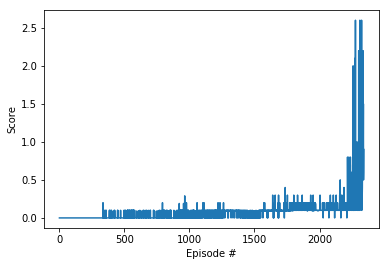

In [6]:
scores = maddpg_train()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [7]:
env.close()